<h1 id="Train-on-Google-Cloud-ML-Engine">Train, deploy, predict on Google Cloud ML Engine</h1>

<p>tags: kaggle, digit, mnist, cnn, esitmator, google cloud, ml-engline, ai-platform, submit, train&nbsp;&nbsp;</p>

<p>read this doc to start off&nbsp;</p>

<p><a href="https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-training-prediction#tensorboard-local" target="_blank">https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-training-prediction#tensorboard-local</a></p>

<h2 id="modification-from-local-run">modification from local run</h2>

<ol>
	<li>import gcsfs in this notebook</li>
	<li>put &#39;gcsfs&#39;&nbsp;in REQUIRED_PACKAGE in setup.py</li>
	<li>change &#39;export&#39; directory name to just the name no &#39;/\&#39;</li>
</ol>

<h2 id="Recommended-project-structure">Recommended project structure</h2>

<p><img src="recommended-project-structure.png" /></p>


<h2 id="to-do-list-before-submit-the-job">to-do list before submit the job</h2>

<ol>
	<li>get or set project id from gcp console</li>
	<li>create a bucket and folders, then upload training data</li>
</ol>




In [1]:
import os
import shutil
from datetime import datetime
import gcsfs
from tensorflow.keras.callbacks import TensorBoard
import json, codecs
import matplotlib.pyplot as plt
import pandas as pd

PROJECT = "________" # REPLACE WITH YOUR PROJECT ID
BUCKET = "________" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
TFVERSION = "1.13"


In [2]:
# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = TFVERSION  # Tensorflow version

In [ ]:
!gcloud auth list
!gcloud config set project $PROJECT
!gcloud config set compute/region $REGION
!gcloud config list project
#!gcloud compute instances list

<h2 id="Train-locally">Train locally (for testing)</h2>


In [4]:
#OUTDIR='trained_test'
#INPDIR='..\data'
#shutil.rmtree(path = OUTDIR, ignore_errors = True) 

In [5]:
# this line won't run until this nb is halted and closed. so instead, run the command in a terminal
#!gcloud ai-platform local train \
#--module-name=trainer.task \
#--package-path=trainer \
#-- \
#--output_dir=$OUTDIR \
#--input_dir=$INPDIR \
#--epochs=2 --learning_rate=0.001 --batch_size=100 

<p>run this command lines in a terminal to train model locally</p>

<pre>
gcloud ai-platform local train --module-name=trainer.task --package-path=trainer --  --output_dir=trained_test --input_dir=..\data --epochs=2 --learning_rate=0.001 --batch_size=100
</pre>


<h2 id="Train-on-Cloud-ML-Engine">Train on Cloud ML Engine</h2>


In [ ]:
OUTDIR='gs://'+BUCKET+'/train_01'
INPDIR='gs://'+BUCKET+'/digit/data'


print("OUTDIR: ",OUTDIR)
print("INPDIR: ",INPDIR)
print("REGION: ", REGION)

print("BUCKET: ", BUCKET)
print("TFVERSION: ", TFVERSION)


In [7]:
#!gsutil -m rm -rf $OUTDIR
# or delete it from console

In [8]:
JOBNAME='kaggle_digit_01_'+datetime.now().strftime("%Y%m%d_%H%M%S")
print("JOBNAME: ", JOBNAME)

JOBNAME:  kaggle_digit_01_20190907_092020


In [9]:
!gcloud ai-platform jobs submit training $JOBNAME \
--region=$REGION \
--module-name=trainer.task \
--package-path=trainer \
--job-dir=$OUTDIR \
--staging-bucket=gs://$BUCKET \
--scale-tier=CUSTOM \
--master-machine-type=n1-standard-4 \
--runtime-version=$TFVERSION \
-- \
--output_dir=$OUTDIR \
--input_dir=$INPDIR \
--epochs=30 --learning_rate=0.001 --batch_size=100 

jobId: kaggle_digit_01_20190907_092020
state: QUEUED


Job [kaggle_digit_01_20190907_092020] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe kaggle_digit_01_20190907_092020

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs kaggle_digit_01_20190907_092020


In [ ]:
print("OUTDIR: ",OUTDIR)

<h2 id="Monitoring-training-with-TensorBoard">Monitoring training with TensorBoard</h2>

<ol>
	<li>open a cloud shell and run the following (replace OUTDIR with actual gs folder)
	<pre>
tensorboard --logdir=OUTDIR --port=8080   </pre>
	</li>
	<li>Select &quot;Preview on port 8080&quot; from the Web Preview menu at the top of the command line.</li>
	<li>in cloud cell window hit ctrl-c to exit.&nbsp;</li>
</ol>


## Deploying and predicting with model

Deploy the model:

In [ ]:
!gsutil ls gs://$BUCKET/train_01/export 

In [12]:
MODEL_NAME='kaggle_digit_cnn'
MODEL_VERSION="t01"
MODEL_LOCATION="gs://________/train_01/export/1567867308/"

In [ ]:
#!gcloud ai-platform versions delete $MODEL_VERSION --model $MODEL_NAME

In [ ]:
#!gcloud ai-platform models delete $MODEL_NAME

In [ ]:
!gcloud ai-platform models create $MODEL_NAME --regions $REGION

In [13]:
!gcloud ai-platform versions create $MODEL_VERSION --model $MODEL_NAME --origin $MODEL_LOCATION --runtime-version=$TFVERSION

Creating version (this might take a few minutes)......
....................................................................................................................................................................................................................................................................done.


## Create input dataset for prediction test

In [14]:
# create json file from test iamges for predict

HEIGHT = 28
WIDTH = 28

#### input test data

test = pd.read_csv('../data/test.csv')
test_images = test.to_numpy().astype('float32')/255.0




In [15]:
test_images.shape

(28000, 784)

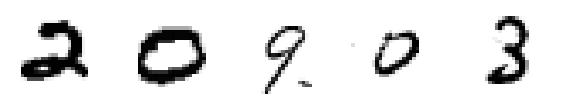

In [16]:
# convert same examples for testing
IMGNO=5
plt.figure(figsize=(20,5))
for i in range(IMGNO):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.axis('off')


In [45]:
JSON_DATA_5img="../data/test_5img.json" 
IMGNO=5
with open(JSON_DATA_5img, "w") as file:
    for i in range(IMGNO):
#        jsondata = {"image": test_images[i].reshape([HEIGHT,WIDTH]).tolist(), "key":  i}
        file.write(json.dumps(jsondata) + '\n')
 


## Local predict (Not working)

In [ ]:
# this maybe a cloud sdk not supporting python 2.7 on windows..
#!gcloud ai-platform local predict \
#--model-dir=.\trained_test\export\1567026070\ \
#--json-instances=test_1.json

## Send data to the prediction service

In [17]:
MODEL_NAME='kaggle_digit_cnn'
MODEL_VERSION="t01"
JSON_DATA="../data/test_5img.json"

In [19]:
!gcloud ai-platform predict \
    --model=$MODEL_NAME \
    --version=$MODEL_VERSION \
    --json-instances=$JSON_DATA

CLASS_IDS  KEY  PROBABILITIES
2          0    [2.157716695000791e-15, 7.120979500507829e-11, 1.0, 1.038207089743004e-10, 1.7021737997588372e-15, 4.439483310655775e-18, 1.1650549231953522e-13, 1.6309280315152108e-11, 2.8516189518219826e-13, 2.620594736747289e-16]
0          1    [0.9999995231628418, 1.5729922572815802e-11, 1.1480251060902447e-07, 3.4986682995175045e-10, 3.331811493367809e-10, 7.699960491436286e-08, 7.116546640872912e-08, 8.946547502830526e-09, 1.7725131584711562e-08, 1.3308539337231196e-07]
9          2    [6.248121464658141e-11, 1.2815258854104172e-09, 2.497069884199732e-09, 1.2406940363973717e-08, 3.862553057842888e-06, 8.85780546133752e-11, 1.1261413676577625e-11, 1.0637103642352486e-08, 2.0143168910635723e-07, 0.9999958276748657]
0          3    [0.9960324168205261, 2.177733327002329e-09, 0.0003500618040561676, 3.4856368529290194e-06, 5.254690904621384e-09, 1.2046750264005368e-08, 1.2734502661260194e-06, 1.9609587980085053e-06, 0.00020687119103968143, 0.003403953975

<h2 id="Summary">Summary</h2>

<p>This is a basic flow for training, deploying model on GCP, and perform one image prediction.</p>

<p>&nbsp;</p>
